In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from data_pre import get_df, data_prep, one_hot, evaluation
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LogisticRegression

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
 #Import Data from statsbombpy
competitions = sb.competitions()
fifa_2022 = sb.matches(competition_id=43, season_id=106)

#Grouped events
events_fifa = sb.competition_events(
    country="International",
    division='FIFA World Cup',
    season="2022",
    gender="male"
)

In [3]:
events_fifa.shape

(234652, 111)

In [4]:
risk_df = get_df(events_fifa)

In [5]:
risk_df.shape

(64415, 7)

In [6]:
risk_df = data_prep(risk_df)
#risk_df = one_hot(risk_df)

Number of risky passes: 10,952
Number of not risky passes: 53,428


In [7]:
risk_df = one_hot(risk_df)

In [8]:
risk_df.corr()

,pass_outcome,pass_length,pass_angle,pass_height_Ground Pass,pass_height_High Pass,pass_height_Low Pass,pass_body_part_Drop Kick,pass_body_part_Head,pass_body_part_Keeper Arm,pass_body_part_Left Foot,pass_body_part_No Touch,pass_body_part_Other,pass_body_part_Right Foot
pass_outcome,1.000000,0.257604,-0.007617,-0.486462,0.452632,0.154454,0.077928,0.121712,-0.039168,0.015330,0.008254,-0.002279,-0.063495
pass_length,0.257604,1.000000,-0.008769,-0.452287,0.588993,-0.090577,0.169439,-0.060487,0.014443,-0.012352,-0.022401,-0.045592,0.022450
pass_angle,-0.007617,-0.008769,1.000000,0.011482,-0.009055,-0.005913,-0.000105,-0.003568,-0.005312,0.143356,0.003547,-0.003702,-0.135063
pass_height_Ground Pass,-0.486462,-0.452287,0.011482,1.000000,-0.788283,-0.515499,-0.092082,-0.358261,0.012973,0.026676,0.015668,-0.097039,0.133222
pass_height_High Pass,0.452632,0.588993,-0.009055,-0.788283,1.000000,-0.120897,0.111687,0.234579,-0.020627,-0.010967,-0.014879,-0.005041,-0.087633
pass_height_Low Pass,0.154454,-0.090577,-0.005913,-0.515499,-0.120897,1.000000,-0.006984,0.251295,0.007798,-0.027762,-0.004556,0.163571,-0.092883
pass_body_part_Drop Kick,0.077928,0.169439,-0.000105,-0.092082,0.111687,-0.006984,1.000000,-0.009815,-0.004645,-0.033251,-0.001738,-0.003014,-0.067364
pass_body_part_Head,0.121712,-0.060487,-0.003568,-0.358261,0.234579,0.251295,-0.009815,1.000000,-0.018073,-0.129368,-0.006762,-0.011726,-0.262093
pass_body_part_Keeper Arm,-0.039168,0.014443,-0.005312,0.012973,-0.020627,0.007798,-0.004645,-0.018073,1.000000,-0.061227,-0.003200,-0.005550,-0.124043
pass_body_part_Left Foot,0.015330,-0.012352,0.143356,0.026676,-0.010967,-0.027762,-0.033251,-0.129368,-0.061227,1.000000,-0.022909,-0.039727,-0.887921


In [9]:
# Find the correlation between the columns
correlation_matrix = risk_df.corr()

# Find the highest correlated columns
highest_correlation = correlation_matrix.unstack().sort_values(ascending=False)

# Print the top correlation pairs (excluding self-correlation and duplicates)
top_correlation_pairs = highest_correlation[(highest_correlation < 2) & (highest_correlation > 0)].head()
print("Top correlated column pairs:")
print(top_correlation_pairs)

Top correlated column pairs:
pass_outcome              pass_outcome                1.0
pass_length               pass_length                 1.0
pass_body_part_Other      pass_body_part_Other        1.0
pass_body_part_No Touch   pass_body_part_No Touch     1.0
pass_body_part_Left Foot  pass_body_part_Left Foot    1.0
dtype: float64


In [10]:
#Drop the cols with multicolinearity
risk_df_multicol = risk_df.drop(columns=['pass_body_part_Keeper Arm', 'pass_height_High Pass','pass_body_part_Other' ])


Logit Model

In [11]:
# Extract the dependent variable (y) and explanatory variables (X)
y = risk_df_multicol.iloc[:, 0]
X = risk_df_multicol.iloc[:, 1:]

# Add a constant term to the explanatory variables for the intercept
X = sm.add_constant(X)

In [12]:
# Fit a logistic regression model (logit)
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.348660
         Iterations 7


In [13]:
print("Logit Regression Results:")
print(logit_result.summary())

Logit Regression Results:
                           Logit Regression Results                           
Dep. Variable:           pass_outcome   No. Observations:                64380
Model:                          Logit   Df Residuals:                    64370
Method:                           MLE   Df Model:                            9
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                  0.2355
Time:                        13:09:53   Log-Likelihood:                -22447.
converged:                       True   LL-Null:                       -29362.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.3172      0.169     -7.791      0.000      -1.649      -0.986
pass_length                  -0.0052      0.001     -5.669  

Logit Model - Prediction - Classification

In [18]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Splitting the data into validation test set
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Add a constant term to the explanatory variables for the intercept
X_test = sm.add_constant(X_test)
X_test_val = sm.add_constant(X_test_val)

In [24]:
# Fit a logistic regression model (logit)
logit_model = sm.Logit(y_train, X_train)
logit_result = logit_model.fit()

# Predict on the test set
logit_predictions = logit_result.predict(X_test)
logit_predictions_binary = np.round(logit_predictions)

Optimization terminated successfully.
         Current function value: 0.349689
         Iterations 7


In [17]:
# Evaluate logit model performance
print("\nLogit Model Performance:")
print("Accuracy:", accuracy_score(y_test, logit_predictions_binary))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, logit_predictions_binary))
#print("\nClassification Report:\n", classification_report(y_test, logit_predictions_binary))


Logit Model Performance:
Accuracy: 0.8510406958682821

Confusion Matrix:
 [[19867  1486]
 [ 2350  2049]]


Tuning - Logit

In [23]:
# For tuning employ the test set (20% of data)

# Fit a logistic regression model (logit)
logit_model_tun = sm.Logit(y_train_val, X_train_val)
logit_result_tun = logit_model_tun.fit()

# Predict on the test set
logit_predictions_tun = logit_result_tun.predict(X_test_val)
logit_predictions_binary_tun = np.round(logit_predictions_tun)

thresholds = []
for i in range(15, 100, 5):
    thresholds.append(i/100)

accuracy_values = []
# Calculate accuracy for each threshold
for threshold in thresholds:
    y_pred_tun = (logit_predictions_tun >= threshold).astype(int)
    accuracy=  accuracy_score(y_test_val, y_pred_tun)*100
    accuracy_values.append(accuracy)
    #print(f'Threshold: {threshold}, Accuracy: {accuracy:.2f}')

Optimization terminated successfully.
         Current function value: 0.342647
         Iterations 8


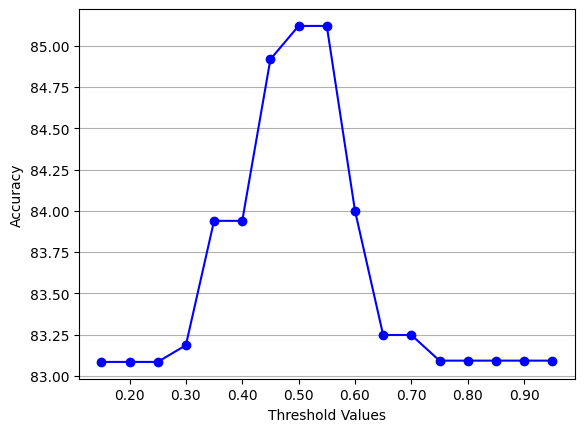

In [21]:
# Plot the line graph
plt.plot(thresholds, accuracy_values, color='blue', marker='o')
#plt.title('Threshold Tuning')
plt.xlabel('Threshold Values')
plt.ylabel('Accuracy')
plt.grid(axis='y')  # Remove vertical grid lines
# Format x-axis ticks to display only 2 decimal places
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.2f}".format(x)))
plt.savefig(f'threshold_tuning.png', bbox_inches='tight')

plt.show()

Evaluation - Logit

In [25]:
df_eval_logit = evaluation(y_test, logit_predictions_binary)

In [26]:
df_eval_logit

,Value
Accuracy,85.10
Misclassification Rate,14.90
Sensitivity,46.58
Specificity,93.04
Precision,57.96


Probit Model

In [27]:
# Fit a probit regression model
probit_model = sm.Probit(y, X)
probit_result = probit_model.fit()

Optimization terminated successfully.
         Current function value: 0.348478
         Iterations 7


In [28]:
print("Probit Regression Results:")
print(probit_result.summary())

Probit Regression Results:
                          Probit Regression Results                           
Dep. Variable:           pass_outcome   No. Observations:                64380
Model:                         Probit   Df Residuals:                    64370
Method:                           MLE   Df Model:                            9
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                  0.2359
Time:                        13:14:20   Log-Likelihood:                -22435.
converged:                       True   LL-Null:                       -29362.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6786      0.088     -7.727      0.000      -0.851      -0.506
pass_length                  -0.0038      0.001     -7.318 

Prediction - Probit

In [29]:
# Fit a probit regression model
probit_model = sm.Probit(y_train, X_train)
probit_result = probit_model.fit()

# Predict on the test set
probit_predictions = probit_result.predict(X_test)
probit_predictions_binary = np.round(probit_predictions)

Optimization terminated successfully.
         Current function value: 0.349463
         Iterations 6


In [30]:
# For tuning employ the test set (20% of data)

# Fit a probit regression model (probit)
probit_model_tun = sm.Probit(y_train_val, X_train_val)
probit_result_tun = probit_model_tun.fit()

# Predict on the test set
probit_predictions_tun = probit_result_tun.predict(X_test_val)
probit_predictions_binary_tun = np.round(probit_predictions_tun)

thresholds = []
for i in range(15, 100, 5):
    thresholds.append(i/100)

accuracy_values = []
# Calculate accuracy for each threshold
for threshold in thresholds:
    y_pred_tun = (probit_predictions_tun >= threshold).astype(int)
    accuracy=  accuracy_score(y_test_val, y_pred_tun)*100
    accuracy_values.append(accuracy)
    #print(f'Threshold: {threshold}, Accuracy: {accuracy:.2f}')

Optimization terminated successfully.
         Current function value: 0.342656
         Iterations 7


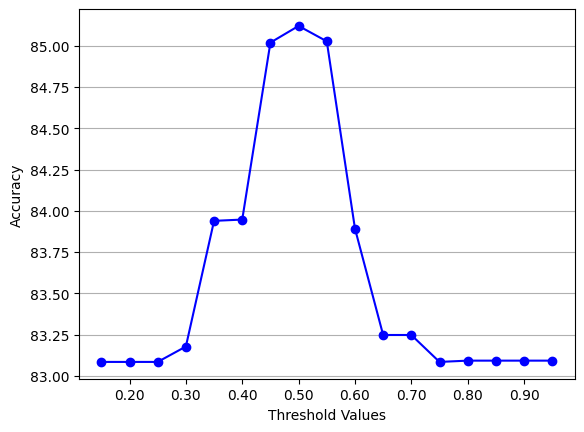

In [31]:
plt.plot(thresholds, accuracy_values, color='blue', marker='o')
#plt.title('Threshold Tuning')
plt.xlabel('Threshold Values')
plt.ylabel('Accuracy')
plt.grid(axis='y')  # Remove vertical grid lines
# Format x-axis ticks to display only 2 decimal places
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.2f}".format(x)))
plt.savefig(f'threshold_tuning.png', bbox_inches='tight')

In [32]:
# Evaluate probit model performance
print("Probit Model Performance:")
print("Accuracy:", accuracy_score(y_test, probit_predictions_binary))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, probit_predictions_binary))
#print("\nClassification Report:\n", classification_report(y_test, probit_predictions_binary))


Probit Model Performance:
Accuracy: 0.8506135445790618

Confusion Matrix:
 [[19872  1481]
 [ 2366  2033]]


In [33]:
df_eval_probit = evaluation(y_test, probit_predictions_binary)

In [34]:
df_eval_logit['values_probit'] = df_eval_probit['Value']
df_eval_logit

,Value,values_probit
Accuracy,85.10,85.06
Misclassification Rate,14.90,14.94
Sensitivity,46.58,46.22
Specificity,93.04,93.06
Precision,57.96,57.85
